In [1]:
'''
L. Gehring
YouTube Trending Video Analysis for Germany
Data Literacy, WS 21/22
''';

In [2]:
'''
Update the trending YT videos and categories for Germany (beginning 12.08.2020)
from https://www.kaggle.com/rsrishav/youtube-trending-video-dataset
This may take up to 20 seconds
'''
!kaggle datasets download rsrishav/youtube-trending-video-dataset -f DE_category_id.json -p ../dat -q
!kaggle datasets download rsrishav/youtube-trending-video-dataset -f DE_youtube_trending_data.csv -p ../dat -q

In [3]:
# Imports
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.colors as col
import matplotlib.pyplot as plt
import urllib.request
import PIL
import seaborn as sns
import tueplots

from PIL import Image
from tueplots import bundles, figsizes
from wordcloud import WordCloud
from wordcloud import get_single_color_func

In [4]:
'''
Use tueplots globally
'''
plt.rcParams.update(bundles.neurips2021(usetex=False))
plt.rcParams.update({"figure.dpi": 600})
plt.rcParams.update(figsizes.neurips2021())
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#cc0000"])   # shaded yt_red

In [5]:
'''
Read and preprocess the trends df for Germany
'''
# Read trends df
multi_trends_time = pd.read_csv('../dat/DE_youtube_trending_data.csv.zip')
multi_trends = multi_trends_time.copy()  # copy with truncated hours

# Convert string dates to datetime
multi_trends['publishedAt']= pd.to_datetime(multi_trends_time['publishedAt']).dt.normalize()
multi_trends['trending_date']= pd.to_datetime(multi_trends_time['trending_date']).dt.normalize()

# Videos can appear multiple times in the df, if they trend longer than one day.
# Drop duplicate videos and keep the latest entry
trends = multi_trends.sort_values(['publishedAt', 'trending_date'], ascending=False).\
    drop_duplicates('video_id', keep='first').sort_index().reset_index(drop=True)

# Drop duplicate videos and keep the first entry
trends_start = multi_trends.sort_values(['publishedAt', 'trending_date'], ascending=False).\
    drop_duplicates('video_id', keep='last').sort_index().reset_index(drop=True)

In [6]:
'''
Augment the df with trending duration in days per video
and duration to first appereance in trending after release.
'''
# Sort both df by video_id
trends.sort_values(by=['video_id'], inplace=True, ignore_index=True)
trends_start.sort_values(by=['video_id'], inplace=True, ignore_index=True)

# Calculate trending duration and onset duration (corrected by +1 day, to include first and last trending day)
trends['trending_duration'] =  ((trends['trending_date'].values - trends_start['trending_date'].values)\
    .astype('timedelta64[D]')/ np.timedelta64(1, 'D')).astype('int') + 1

# Onset duration for videos
trends['onset_duration'] = (trends_start['trending_date'] - trends['publishedAt']).astype('timedelta64[D]').astype('int') 

# Re-sort by release date and video id
trends.sort_values(['trending_date', 'video_id'], inplace=True)
trends.reset_index(drop=True, inplace=True)

In [7]:
'''
Replace categroy id's with catgeory names and
convert '|' separated tags into arrays
'''
# Read and build category dict
with open('../dat/DE_category_id.json','r') as f:
    cat_json = json.loads(f.read())
categories = pd.json_normalize(cat_json, record_path =['items'])[["id", "snippet.title"]]
categories.rename(columns={"id": "cat_id", "snippet.title": "cat_title"}, inplace=True)
cat_dict = dict(zip(pd.to_numeric(categories.cat_id), categories.cat_title))

#! ID 29 seems to be missing -> add manually from https://gist.github.com/dgp/1b24bf2961521bd75d6c
cat_dict[29] = 'Nonprofits & Activism'

# Replace cat_id with cat_title in the trends df
trends.replace({"categoryId": cat_dict},inplace=True)
trends.rename(columns={"categoryId": "category"}, inplace=True)

# Convert tagslist to array
trends['tags'] = trends['tags'].apply(lambda x: x.split('|'))

# Convert titles to words arrays
trends['title'] = trends['title'].apply(lambda x: x.split(' '))

In [8]:
# Show trends df example
trends.head(2)

,video_id,title,publishedAt,channelId,channelTitle,category,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,trending_duration,onset_duration
0,-vECGH3LTa8,"[Winta, Mekonen, Dendani, /ደንዳኒ, New, Eritrean...",2020-08-08 00:00:00+00:00,UC-Zcld_yldnjHwF3kFBd7Bw,MEGARYA Entertainment,Music,2020-08-12 00:00:00+00:00,"[#eritrean music winta mokenen, Eritrean new m...",294934,16261,846,2148,https://i.ytimg.com/vi/-vECGH3LTa8/default.jpg,False,False,#eritreanmusic #tigrignamusic #megaryamusic℗ ©...,1,4
1,0ShPCv3D938,"[Wir, beantworten, UNANGENEHME, FRAGEN!, (Mit,...",2020-08-09 00:00:00+00:00,UCDmbhGe7-wC1a55l5ZYAZJw,Papaplatte,Gaming,2020-08-12 00:00:00+00:00,"[Papaplatte, papaplatte twitch best of, papapl...",217712,30404,324,1448,https://i.ytimg.com/vi/0ShPCv3D938/default.jpg,False,False,"Heute haben wir für euch mal wieder ein Video,...",1,3


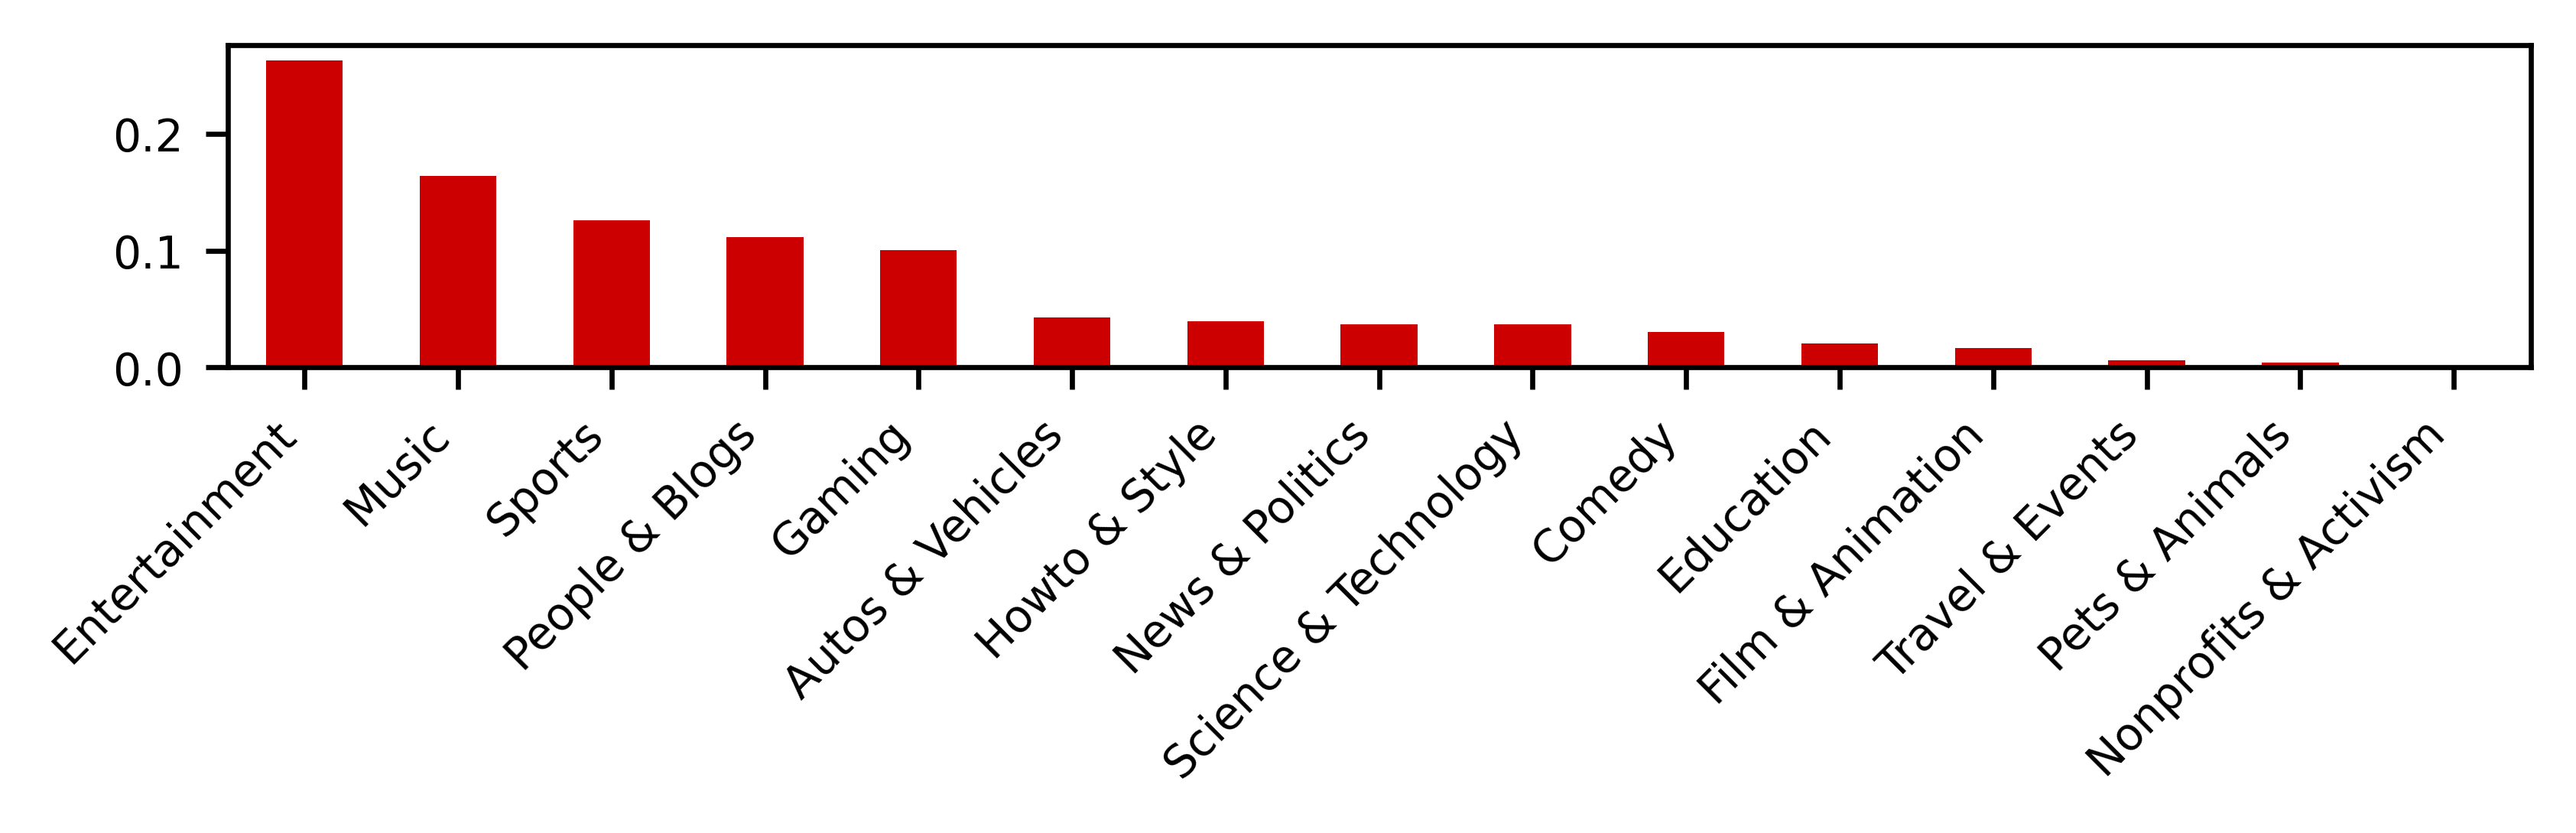

In [9]:
'''
Plot category, tag, channel and title words popularity
'''
# Plot category popularity
pop_cats = trends.category.value_counts(normalize=True);
ax = pop_cats.plot(kind='bar');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig = ax.get_figure()
fig.savefig('../doc/neurips2021/fig/pop_cat.png')

# !!! See wordclouds for better tag, channel, titles visualization

# # Plot the most popular tags
# plt.title('Popular tags')
# tags = pd.Series(np.concatenate(trends.tags));
# pop_tags = tags.value_counts(normalize=True);
# pop_tags[0:30].plot(kind='bar');

# # Plot channel popularity
# plt.subplot(2, 2, 1)
# plt.title('Popular channels')
# pop_channels = trends.channelTitle.value_counts(normalize=True);
# pop_channels[0:30].plot(kind='bar');

# # Plot the 30 most popular title words
# plt.title('Popular title words')
# titles = pd.Series(np.concatenate(trends.title));
# pop_titles = titles.value_counts(normalize=True);
# pop_titles[0:30].plot(kind='bar');

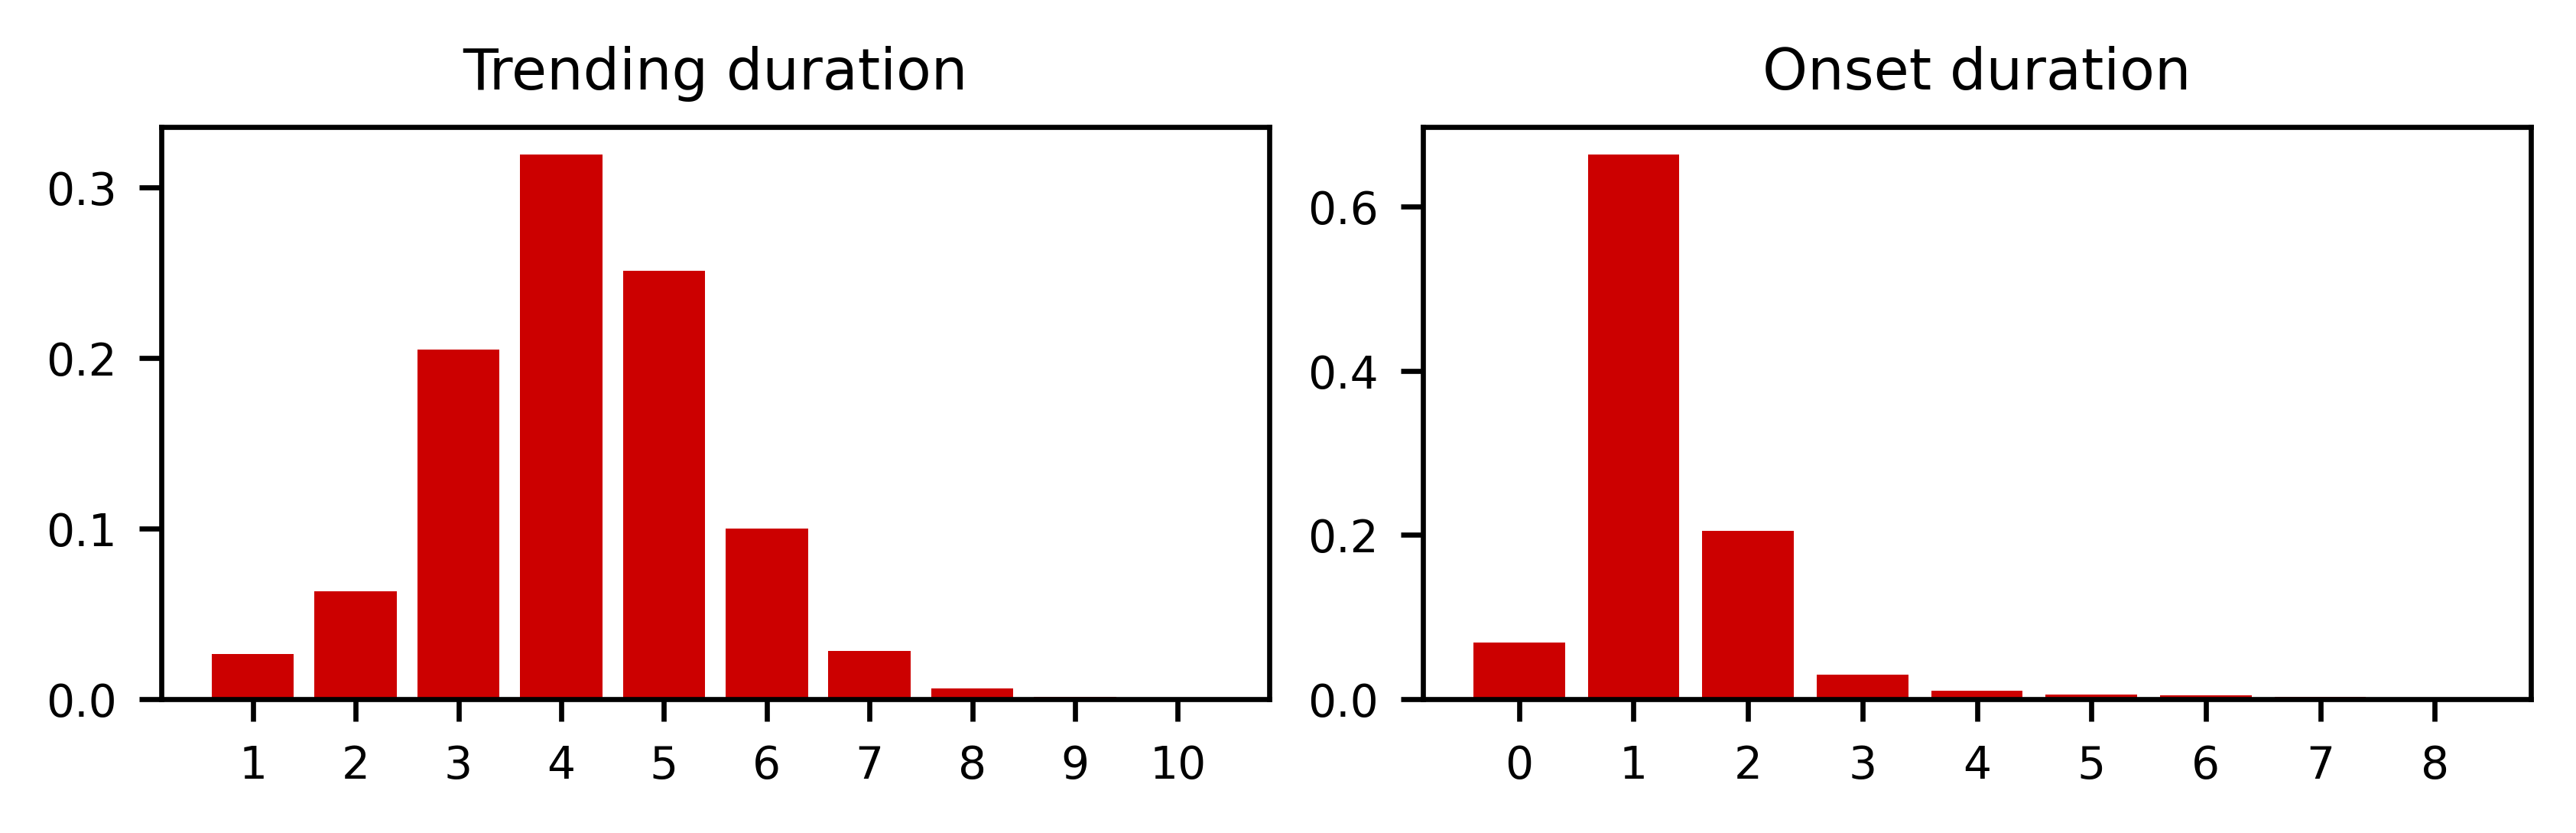

In [10]:
'''
Plot trending duration and onset duration histograms
'''
fig, ax = plt.subplots(1, 2, sharey=False)
plt.subplot(1, 2, 1)
plt.title('Trending duration')
labels, counts = np.unique(trends['trending_duration'], return_counts=True);
plt.bar(labels, counts/counts.sum(), align='center');
plt.gca().set_xticks(labels);
plt.subplot(1, 2, 2);
plt.title('Onset duration')
labels, counts = np.unique(trends['onset_duration'], return_counts=True);
plt.bar(labels[0:9], counts[0:9]/counts.sum(), align='center');
plt.gca().set_xticks(labels[0:9]);
fig.savefig('../doc/neurips2021/fig/durations.png')

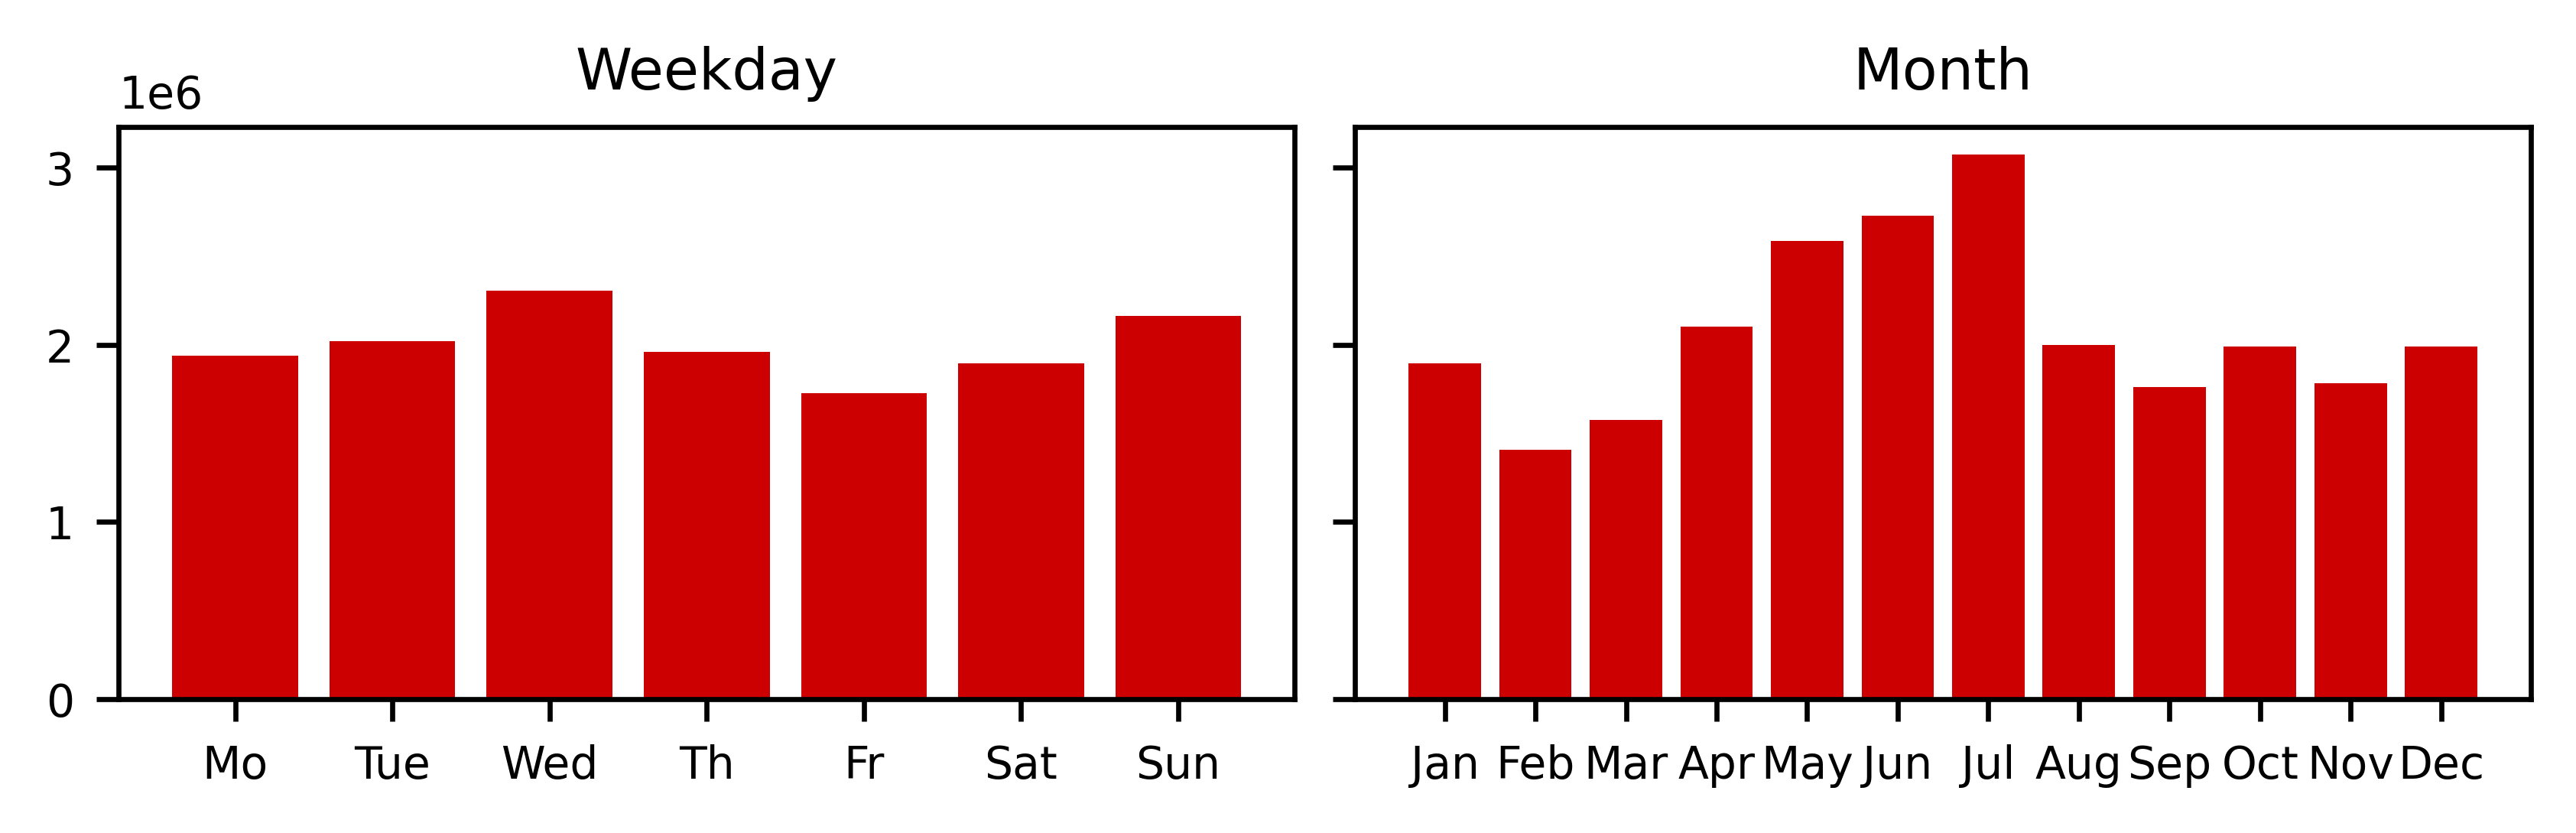

In [11]:
'''
Plot average view counts of unique trending videos by weekday and month
'''
# Subset trends and weekdays/months
trends['weekday'] = trends.trending_date.dt.weekday
trends['month'] = trends.trending_date.dt.month

# Label definitions
weekday_labels = ['Mo', 'Tue', 'Wed', 'Th', 'Fr', 'Sat', 'Sun']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot weekday distribution
fig, ax = plt.subplots(1, 2, sharey=True)
plt.subplot(1, 2, 1)
plt.title('Weekday')
labels, counts = weekday_labels, trends.groupby('weekday')['view_count'].mean()
plt.bar(labels, counts, align='center');
plt.gca().set_xticks(labels);

# Plot month distribution
plt.subplot(1, 2, 2);
plt.title('Month')
labels, counts = month_labels, trends.groupby('month')['view_count'].mean()
plt.bar(labels, counts, align='center');
plt.gca().set_xticks(labels);
fig.savefig('../doc/neurips2021/fig/views.png')

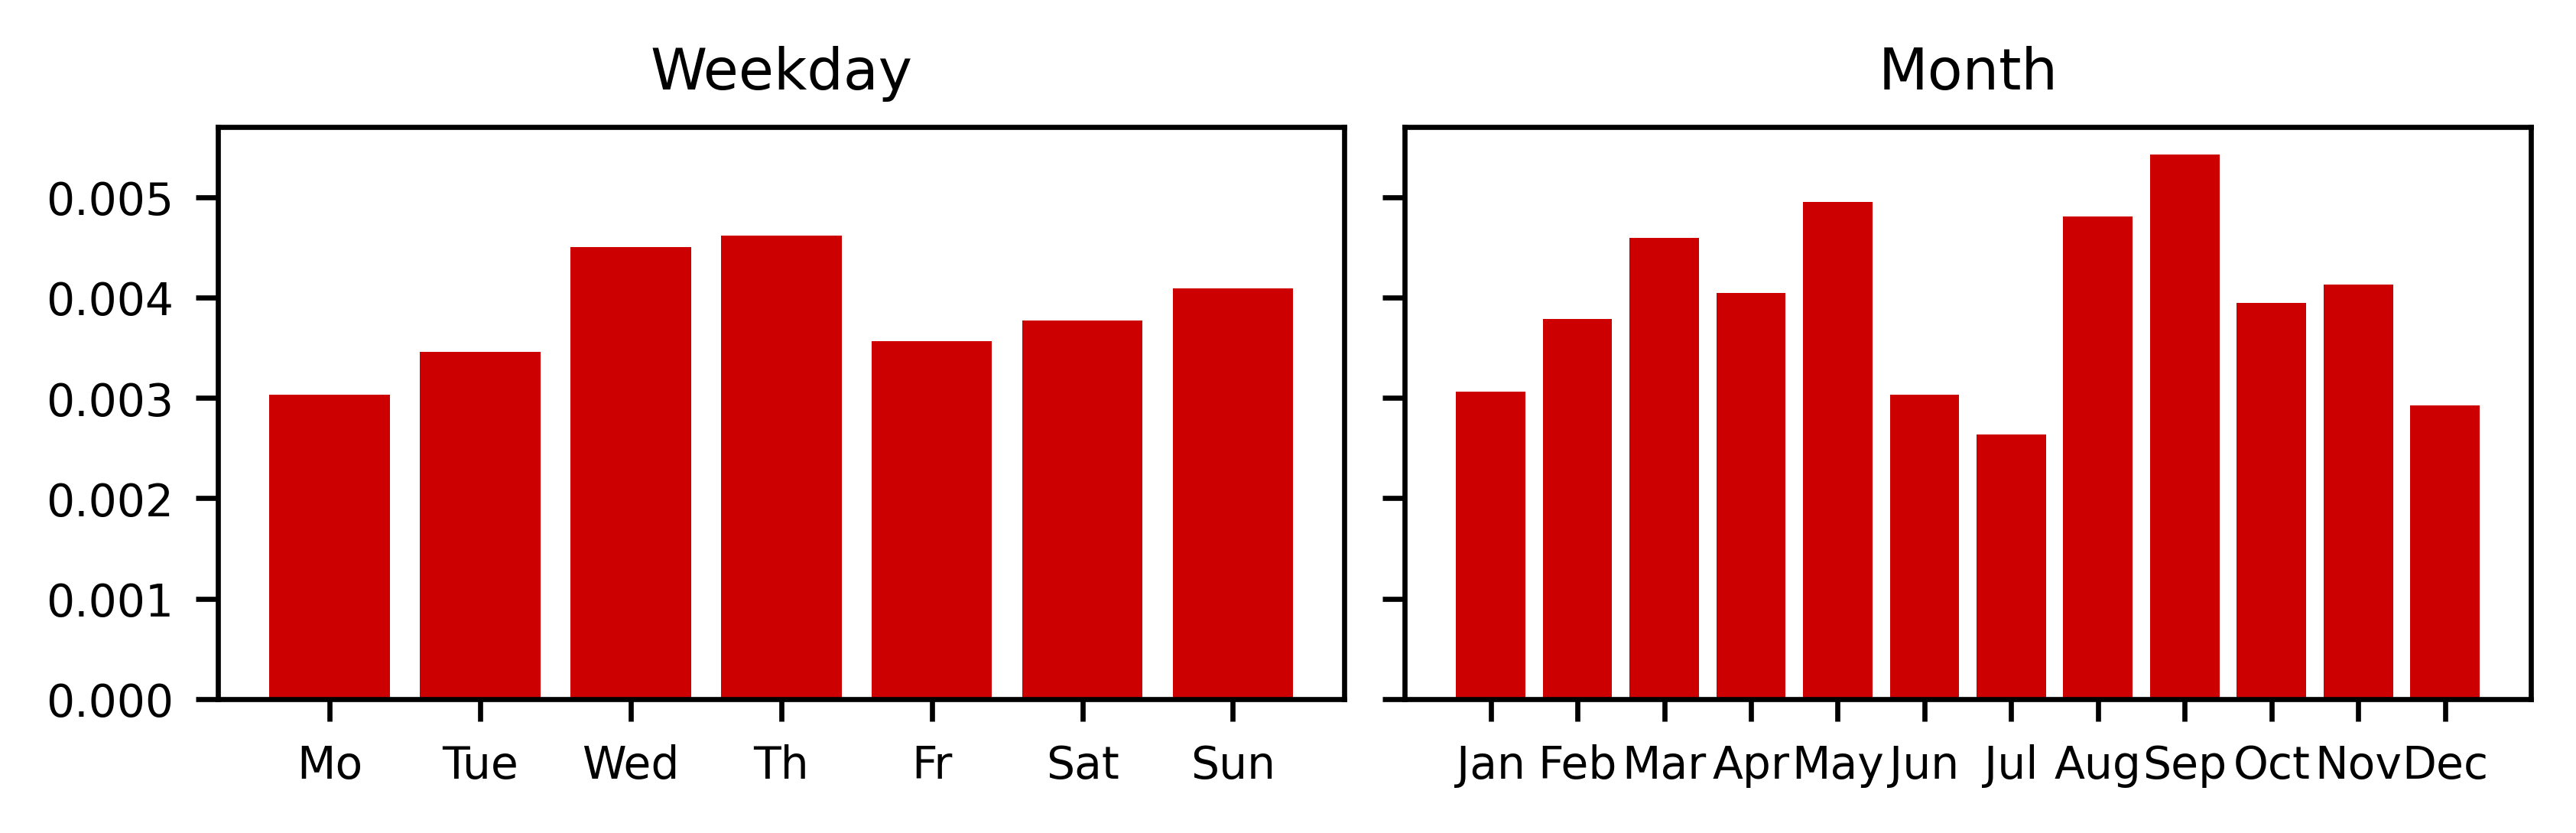

In [12]:
'''
Plot average number of comments per views and weekday/month
'''
# Plot weekday distribution
comments_day = trends.groupby('weekday')['comment_count'].mean()
views_day = trends.groupby('weekday')['view_count'].mean()
comments_month = trends.groupby('month')['comment_count'].mean()
views_month = trends.groupby('month')['view_count'].mean()

# Plot weekday distribution
fig, ax = plt.subplots(1, 2, sharey=True)
plt.subplot(1, 2, 1)
plt.title('Weekday')
labels, counts = weekday_labels, (comments_day / views_day)
plt.bar(labels, counts, align='center');
plt.gca().set_xticks(labels);

# Plot month distribution
plt.subplot(1, 2, 2);
plt.title('Month')
labels, counts = month_labels, (comments_month / views_month)
plt.bar(labels, counts, align='center');
plt.gca().set_xticks(labels);
fig.savefig('../doc/neurips2021/fig/comments.png')

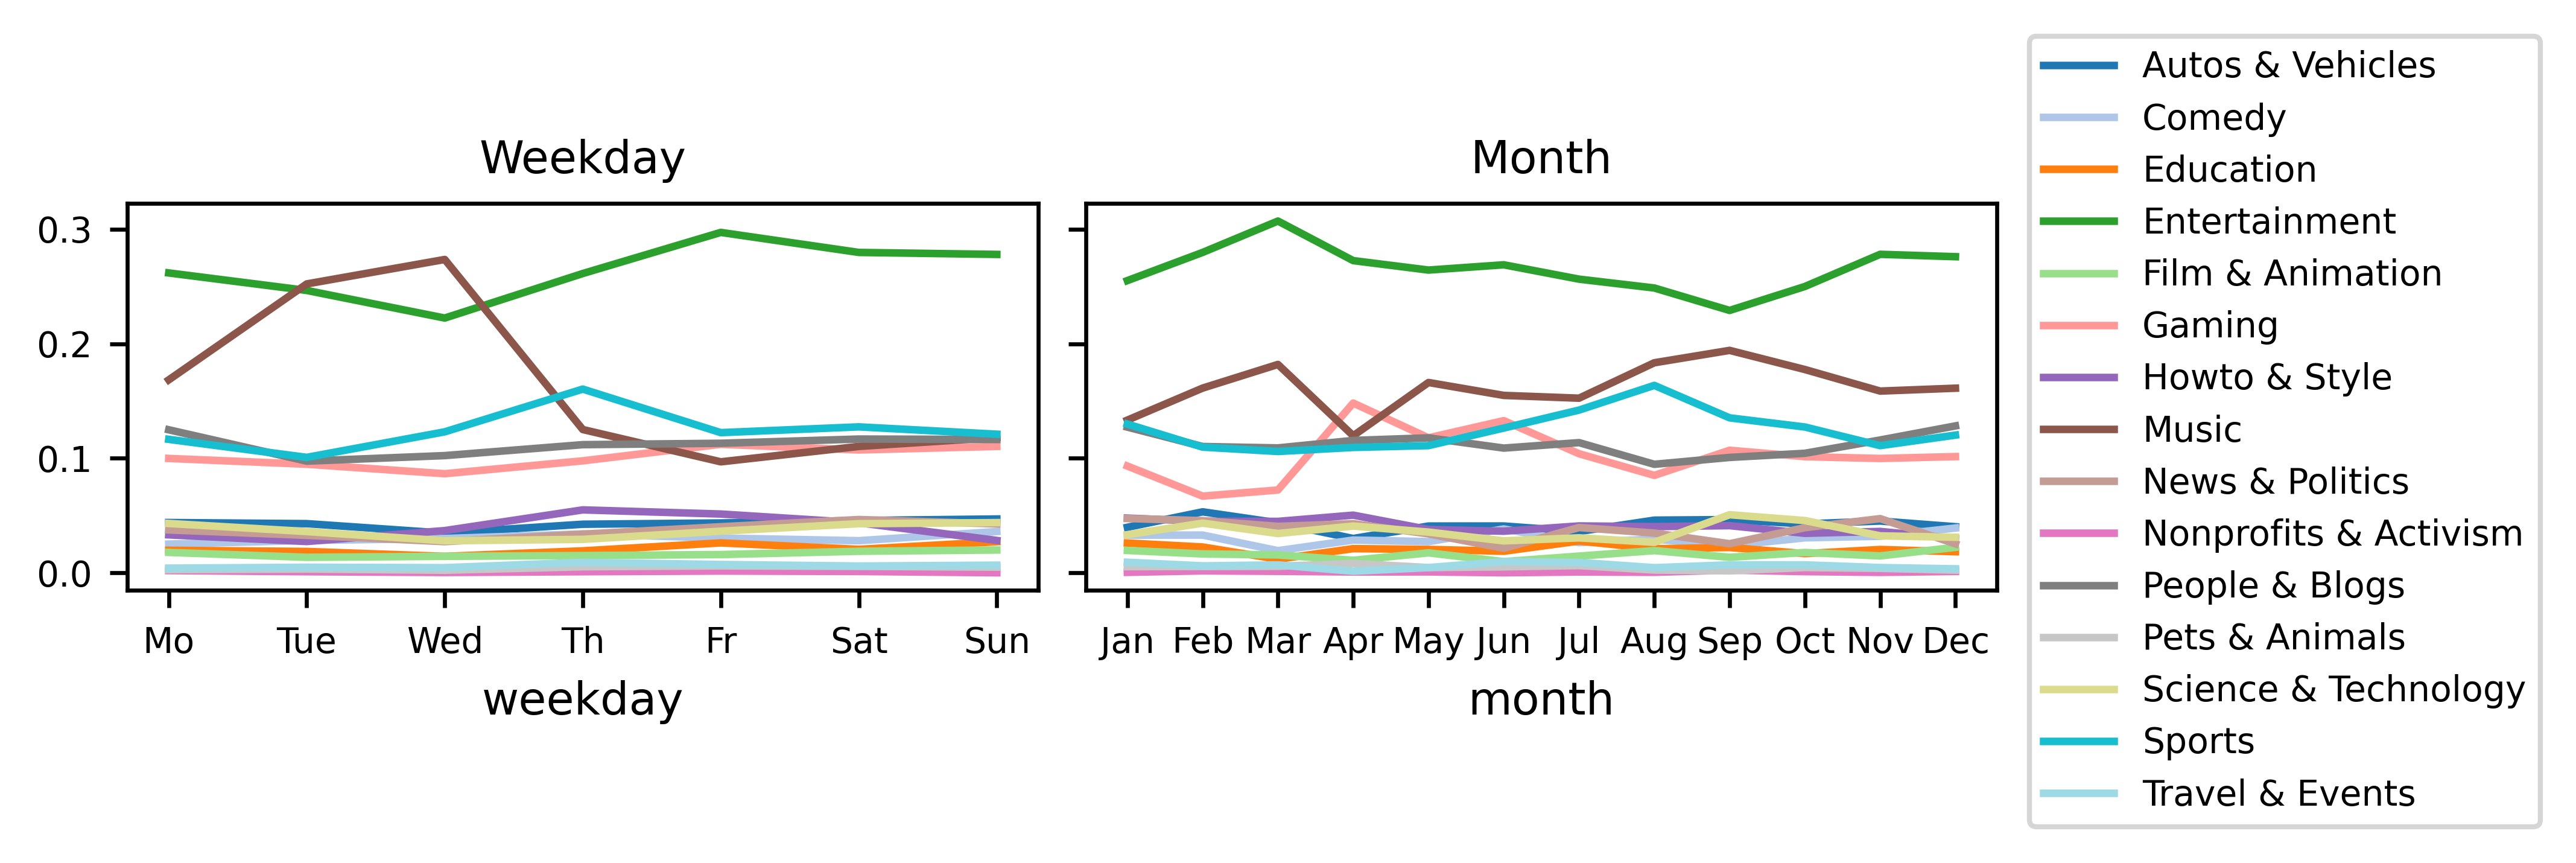

In [13]:
'''
Plot relative category composition of unique videos trending per weekday/month
'''
fig, ax = plt.subplots(1, 2, sharey=True)

# Plot relative category composition of unique videos trending per month
cat_counts = trends.groupby(['weekday', 'category']).size().unstack();
cat_counts = cat_counts.div(cat_counts.sum(axis=1), axis=0).fillna(0);

cat_counts.plot(ax=ax[0], kind='line', cmap=plt.cm.tab20, title='Weekday', legend=False);
ax[0].set_xticks(np.arange(0,7,1));
ax[0].set_xticklabels(weekday_labels);

# Plot relative category composition of unique videos trending per month
cat_counts = trends.groupby(['month', 'category']).size().unstack();
cat_counts = cat_counts.div(cat_counts.sum(axis=1), axis=0).fillna(0);

cat_counts.plot(ax=ax[1], kind='line', cmap=plt.cm.tab20, title='Month', legend=False);
ax[1].set_xticks(np.arange(1,13,1));
ax[1].set_xticklabels(month_labels);

legend = fig.legend(labels=cat_counts.columns, loc='center left', bbox_to_anchor=(1.0, 0.5));
fig.savefig('../doc/neurips2021/fig/cat_weekday_month.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [14]:
'''
Plot correlation matrix
'''
# Normalize likes, dislikes and comment count by views
trends_norm = trends.copy()
trends_norm['likes'] = trends_norm['likes']/trends_norm['view_count']
trends_norm['dislikes'] = trends_norm['dislikes']/trends_norm['view_count']
trends_norm['comment_count'] = trends_norm['comment_count']/trends_norm['view_count']

# Correlate and extract upper triangle
trends_norm.drop(columns=['weekday', 'month'], inplace=True)
corr = trends_norm.rename(columns={"view_count": "views", "comment_count": "comments", \
                                   "trending_duration": "trending duration", "onset_duration": "onset duration"})\
    .drop(columns=['comments_disabled', 'ratings_disabled']).corr()
corr_triang = corr.where(np.triu(np.ones(corr.shape)).astype(bool))

# Highlight cells with corr greater 0.1(\-0.1) except 1.0
def highlight_pos(s):
    is_pos_corr = (s > 0.1) & (s != 1.0)
    return ['background-color: #F55239' if v else '' for v in is_pos_corr]
def highlight_pos_strong(s):
    is_pos_corr_strong = (s > 0.15) & (s != 1.0)
    return ['background-color: #E63328' if v else '' for v in is_pos_corr_strong]
def highlight_neg(s):
    is_neg_corr = (s < -0.1) & (s != 1.0)
    return ['background-color: #FDC5AD' if v else '' for v in is_neg_corr]

corr_triang.to_latex('../doc/neurips2021/fig/corr_tab.tex', na_rep='', float_format="%.2f");

style = corr_triang.style.apply(highlight_pos, axis=0)
style.apply(highlight_pos_strong, axis=0)
style.apply(highlight_neg, axis=0)

,views,likes,dislikes,comments,trending duration,onset duration
views,1.000000,-0.027747,-0.016408,-0.017535,0.132592,0.195004
likes,nan,1.000000,0.016433,0.285500,-0.002868,-0.051907
dislikes,nan,nan,1.000000,0.192360,0.013879,0.009120
comments,nan,nan,nan,1.000000,-0.014657,-0.066283
trending duration,nan,nan,nan,nan,1.000000,-0.119153
onset duration,nan,nan,nan,nan,nan,1.000000


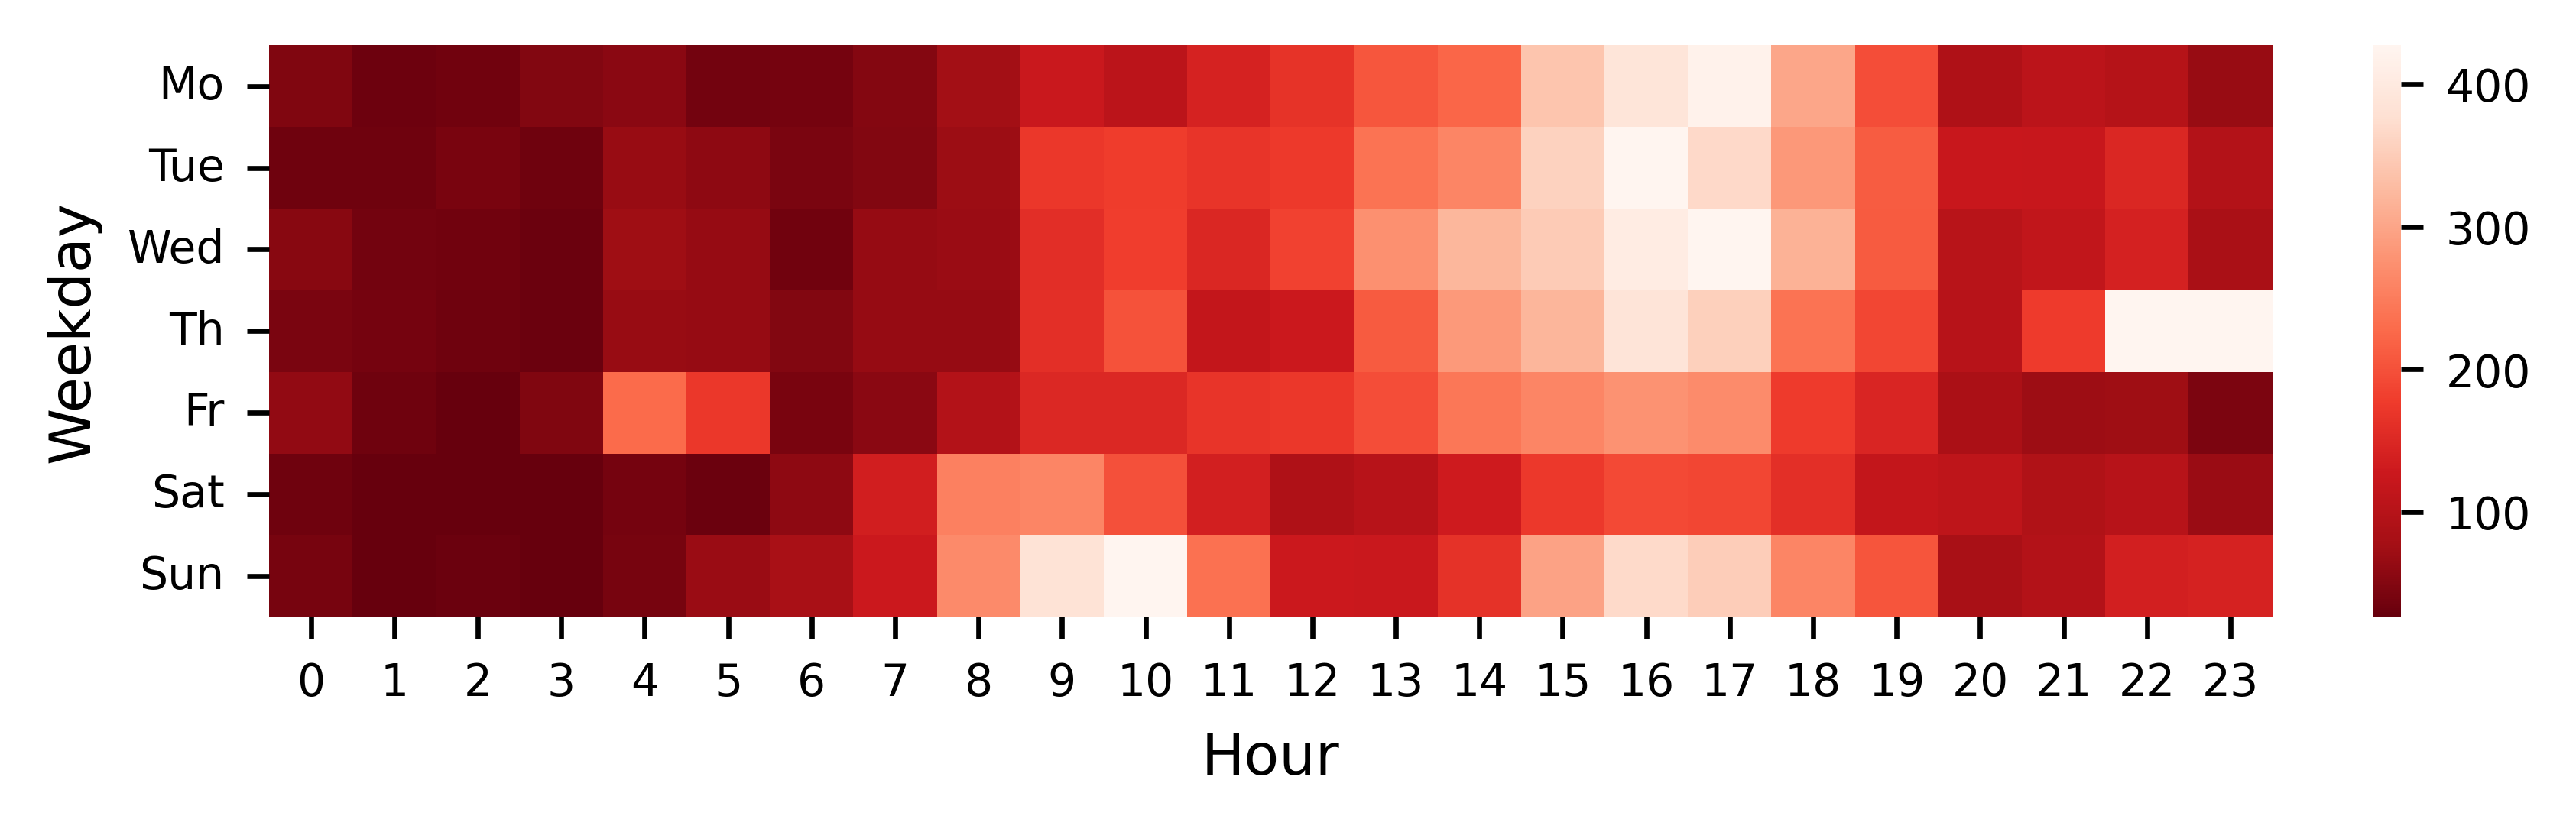

In [15]:
'''
Plot frequency of publishing times by weekday and hour
'''
# Publishing time, heatmap
trends_time = multi_trends_time.sort_values(['publishedAt', 'trending_date'], ascending=False).\
    drop_duplicates('video_id', keep='first').sort_index().reset_index(drop=True)

trends_time['publishedAt'] = pd.to_datetime(trends_time['publishedAt'])
trends_time['hour'] = trends_time['publishedAt'].dt.hour
trends_time['weekday'] = trends_time['publishedAt'].dt.weekday

cal = trends_time.groupby(['weekday', 'hour']).size().unstack();
cal_norm = cal.divide(cal.sum().sum());

fig, ax = plt.subplots();
heatmap = sns.heatmap(cal, ax=ax, cmap='Reds_r', robust=True, yticklabels=weekday_labels);
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_ylabel('Weekday')
ax.set_xlabel('Hour')
fig.savefig('../doc/neurips2021/fig/pub_time.png')

In [16]:
'''
Generate Wordclouds for tags, channels and titles
with the "youtube color" and logo, source: https://logosmarken.com/youtube-logo/
'''
# Load youtube logo shape
yt_mask = np.array(Image.open("../dat/yt_mask.png"))

# Plot tag popularity
tags = pd.Series(np.concatenate(trends.tags));
pop_tags = tags.value_counts(normalize=True);
wc = WordCloud(background_color='white', color_func=get_single_color_func('#FF0000'), width=1920, height=1080, mask=yt_mask) \
    .generate_from_frequencies(pop_tags.drop('[None]').to_dict());
wc.to_file('../doc/neurips2021/fig/tags_wordcloud.png');

# Plot channel popularity
pop_channels = trends.channelTitle.value_counts(normalize=True);
wc = WordCloud(background_color='white', color_func=get_single_color_func('#FF0000'), width=1920, height=1080, mask=yt_mask) \
    .generate_from_frequencies(pop_channels.to_dict());
wc.to_file('../doc/neurips2021/fig/channels_wordcloud.png');

# Plot title popularity
titles = pd.Series(np.concatenate(trends.title));
pop_titles = titles.value_counts(normalize=True);
pop_titles_dict = pop_titles[0:1000].to_dict()
wc = WordCloud(background_color='white', color_func=get_single_color_func('#FF0000'), min_word_length=3, width=1920, height=1080, mask=yt_mask) \
    .generate_from_frequencies({k:pop_titles_dict[k] for k in pop_titles_dict if len(k)>=4});
wc.to_file('../doc/neurips2021/fig/titles_wordcloud.png');

In [17]:
# Update average thumbnail flag
produceThumbnail = False

In [18]:
'''
Download thumbnails
'''
if produceThumbnail:
    broken_link = []
    image_urls = trends.thumbnail_link

    # Change into image folder
    if not (os.getcwd().rsplit('\\', 1)[-1] == 'thumbnails'):
        os.chdir('..\\dat\\thumbnails')
    
    # Download images, that do not yet exist
    for idx, img in enumerate(image_urls):
        file_name = trends['video_id'][idx]
        if not os.path.isfile(file_name + '.png'):
            try:
                urllib.request.urlretrieve(img, file_name + '.png')
            except urllib.error.HTTPError:
                broken_link.append(idx)

    # Change back into src folder
    os.chdir('..\..\src')

    print("{:.1%}".format(len(broken_link)/len(image_urls)) + ' of image links are broken')

In [19]:
'''
Average all thumbnails into one image
Code source: https://stackoverflow.com/questions/17291455/how-to-get-an-average-picture-from-100-pictures-using-pil
'''
if produceThumbnail:
    # Change into image folder
    if not (os.getcwd().rsplit('\\', 1)[-1] == 'thumbnails'):
        os.chdir('..\\dat\\thumbnails')

    # Access all PNG files in directory
    allfiles=os.listdir(os.getcwd())
    imlist=[filename for filename in allfiles if  filename[-4:] in [".png",".PNG"]]

    # Assuming all images are the same size, get dimensions of first image
    w,h=Image.open(imlist[0]).size
    N=len(imlist)

    # Create a numpy array of floats to store the average (assume RGB images)
    arr=np.zeros((h,w,3),float)

    # Build up average pixel intensities, casting each image as an array of floats
    for im in imlist:
        imarr=np.array(Image.open(im),dtype=float)
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)
    
    # Change back into dat folder
    os.chdir('..\\')
    
    # Generate and save final image
    out=Image.fromarray(arr,mode="RGB")
    out.save("../doc/neurips2021/fig/average_thumbnail.png")
    
    # Change back into src folder
    os.chdir('..\src')